In [1]:
import glob
import json
import os.path
from os.path import basename

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.metrics import f1_score

overlap_thresholds = [0.1, 0.2, 0.5]
channels = ['EEG F3-A2', 'EEG F4-A1', 'EEG C3-A2', 'EEG C4-A1']

# load nikitin sleep stages

In [2]:
# compare sleep stages
pred_path = '../../output/annotations/nikitin/pred_sleep_stages/'
pred_files = glob.glob(pred_path + '*sleepstages.txt')

gt_path = '../../output/annotations/nikitin/gt_sleep_stages/'
gt_files = glob.glob(gt_path + '*.txt')

pred_ids = [f.split('/')[-1].split('_')[0] for f in pred_files]
gt_ids = [f.split('/')[-1].split('_')[0] for f in gt_files]

unq_ids = list(set(pred_ids) & set(gt_ids))
pred_stages_all = {}
gt_stages_all = {}

for f_id in sorted(unq_ids, key=lambda x: int(x[1:])):
    pred_file = [f for f in pred_files if f_id + '_' in f][0]
    gt_file = [f for f in gt_files if f_id + '_' in f][0]

    with open(pred_file, 'r') as f:
        pred_stages = f.read().split(' ')
    pred_stages = [int(s) for s in pred_stages if s != '']
    pred_stages = [s if s != 5 else 4 for s in pred_stages]

    gt_df = pd.read_csv(gt_file, sep=',')
    gt_stages = gt_df['Annotation'].values
    stage_mapping = {'Wake': 0, 'N1': 1, 'N2': 2, 'N3': 3, 'R': 4}
    gt_stages = [stage_mapping[s] for s in gt_stages]

    pred_stages_all[f_id] = pred_stages
    gt_stages_all[f_id] = gt_stages

f1_scores_nikitin = []
for s_id in unq_ids:
    f1_scores_nikitin.append(f1_score(gt_stages_all[s_id], pred_stages_all[s_id], average='macro'))

# load DOD sleep stages

In [3]:
dod_path = os.path.expanduser("~/data/dreem-learning-evaluation/scorers/")
scorers = [f'scorer_{i}' for i in range(1, 6)]
NOT_SCORED = -1
f1_scores_dod = {}

for data_subset in ["dodh", "dodo"]:
    recordings = glob.glob(os.path.join(dod_path, data_subset, scorers[0], "*.json"))
    for rec in recordings:
        s_id = basename(rec)[:-5]
        f1_scores_dod[s_id] = {}

        # remove annotations that have not been scored by all scorers
        scores = {}
        for scorer in scorers:
            sta_file = os.path.join(dod_path, data_subset, scorer, basename(rec))
            with open(sta_file) as sf:
                scores[scorer] = np.array(json.load(sf))
        index_min = np.max([np.where(s != NOT_SCORED)[0][0] for s in scores.values()])
        index_max = len(scores[scorers[0]]) - np.max([np.where(s[::-1] != NOT_SCORED)[0][0] for s in scores.values()])
        scores = {k: v[index_min:index_max] for k, v in scores.items()}

        # pairwise comparison of scorers
        for i, scorer1 in enumerate(scorers):
            for scorer2 in scorers[i + 1:]:
                f1 = f1_score(scores[scorer1], scores[scorer2], average='macro')
                f1_scores_dod[s_id][f'{scorer1}-{scorer2}'] = f1

## create plot

Std of expert pairs: 0.12
Quartiles of expert pairs: [0.58936752 0.6852025  0.76209615]
Percentage of expert pairs with F1 < 0.5: 8.75%
Std of predictions: 0.11
Quartiles of predictions: [0.68280458 0.75166615 0.79252791]
p-value: 0.0005


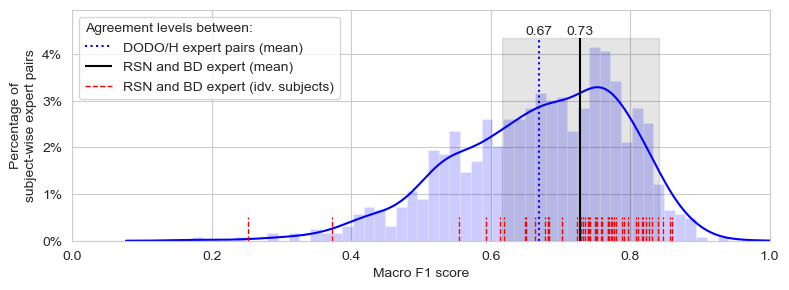

In [4]:
recs = [rec for rec in f1_scores_dod]
data_to_plot = [f1_scores_dod[rec][f'{scorer1}-{scorer2}'] for i, scorer1 in
                enumerate(scorers) for scorer2 in scorers[i + 1:] for rec in recs]
data_to_plot = np.array(data_to_plot)

plt.figure(figsize=(9, 3))
plt.hist(data_to_plot, bins=50, alpha=0.2, density=True, color='blue')
sns.kdeplot(data_to_plot, color='blue')

max_y = plt.ylim()[1]
plt.vlines(np.mean(data_to_plot), 0, max_y, label='DODO/H expert pairs (mean)', linestyles='dotted', color='blue')
plt.text(np.mean(data_to_plot), max_y, f"{np.mean(data_to_plot):.2f}", verticalalignment='bottom',
         horizontalalignment='center')
print(f"Std of expert pairs: {np.std(data_to_plot):.2f}")
print(f"Quartiles of expert pairs: {np.quantile(data_to_plot, [0.25, 0.5, 0.75])}")
print(f"Percentage of expert pairs with F1 < 0.5: {np.sum(data_to_plot < 0.5) / len(data_to_plot) * 100:.2f}%")

plt.vlines(np.mean(f1_scores_nikitin), 0, max_y, color='black', label='RSN and BD expert (mean)', linestyles='solid')
plt.fill_betweenx([0, max_y], np.mean(f1_scores_nikitin) - np.std(f1_scores_nikitin),
                  np.mean(f1_scores_nikitin) + np.std(f1_scores_nikitin), color='black', alpha=0.1)
print(f"Std of predictions: {np.std(f1_scores_nikitin):.2f}")
print(f"Quartiles of predictions: {np.quantile(f1_scores_nikitin, [0.25, 0.5, 0.75])}")
print(f"p-value: {ttest_ind(data_to_plot, f1_scores_nikitin, alternative='less', equal_var=False).pvalue:.4f}")
plt.text(np.mean(f1_scores_nikitin), max_y, f"{np.mean(f1_scores_nikitin):.2f}", verticalalignment='bottom',
         horizontalalignment='center')

plt.vlines(f1_scores_nikitin, 0, 0.5, color='red', label='RSN and BD expert (idv. subjects)', linestyles='dashed',
           linewidth=1)

plt.xlim(0, 1)
y_ticks = plt.yticks()[0][:-1]
plt.ylim(0, max_y + 0.6)
plt.yticks(y_ticks, [f'{y:.0f}%' for y in y_ticks])
plt.xlabel('Macro F1 score')
plt.ylabel('Percentage of\nsubject-wise expert pairs')
leg = plt.legend(loc='upper left', title='Agreement levels between:', alignment='left')
plt.savefig('figures/dod-rsn-vs-expert-pairs-f1.svg')
plt.show()